# TODO + REFERENCES: 
#### - OPTIMIZE PERFORMANCE, convert datatypes [TIPS TO SAVE MEMORY](https://www.kaggle.com/code/pavansanagapati/14-simple-tips-to-save-ram-memory-for-1-gb-dataset/notebook)
#### - EDA Notebooks provide great insights quickly; thank you fellow explorers for making easy the journeys of those who come after you!
- ##### [Time series EDA](https://www.kaggle.com/code/cdeotte/time-series-eda)
- ##### [5star overall explorer](https://www.kaggle.com/code/ambrosm/amex-eda-which-makes-sense/notebook)
- ##### [Correlation explorer](https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline) uses default 'pearson', let's expand this and use other correlation metrics like kendall & spearman

#### - TRAINING-STRATEGY
- #### [5star explorers simple LightGBM](https://www.kaggle.com/code/ambrosm/amex-lightgbm-quickstart)
# Ideas

### 1) IMPORTANT! logloss is simple, doens't factor in that we prefer Recall/Sensitivity over Accuracy, it's okay if we have lots of false positives as long a we have high recall we good ; that is we want to cover all the positive examples and predict all of them as true at the sake of some Negative values wrongly being predicted Positive.
### 1) Customer data records correlate with defaults? Usually there are 13 records per customer but occasionally there are less
- #### Let's find out if there is association between number of records per customer and default rates
- #### FINDING: we have data till 2018-03, and the customers with say 3 records start at 2018-01, and cusotmer with 2 records at 2018-02, maybe some customer has less data because they are new
- #### FINDING: data is from March 2017 to march 2018 (inclusive) hence 13 records per customer max
- ### Some indication that customer who drop early may default [This notebook explores this phenomenon with presence vs target graph](https://www.kaggle.com/code/datark1/american-express-eda)

### X) Test data; why do we have 2x test data than train data!! (INVALIDATED: this is odd; maybe they renamed it wrong :'D, predictions are all 0 in sample submission)
- #### INVALIDATED: (values are all 0 as predictions) we can use Test data for training as well assuming sample_submission.csv has true labels

In [183]:
WHERE_THIS = "local" # local|kaggle

if WHERE_THIS == "kaggle":
    INPUT_PATH = "/kaggle/input/amex-default-prediction/"
    OUTPUT_PATH = "/kaggle/working/"
    TEMP_PATH = "/kaggle/temp/"
elif WHERE_THIS == "local":
    INPUT_PATH = "input/amex-default-prediction/"
    OUTPUT_PATH = "working/"
    TEMP_PATH = "temp/"

In [141]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import gc
import os
from datetime import datetime

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display, HTML
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.model_selection import StratifiedKFold
import plotly.express as pltex

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


for dirname, _, filenames in os.walk(INPUT_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input/amex-default-prediction/sample_submission.csv
input/amex-default-prediction/test_data.csv
input/amex-default-prediction/train_data.csv
input/amex-default-prediction/train_labels.csv


In [166]:
df_iterator = pd.read_csv(f"{INPUT_PATH}/train_data.csv", chunksize=100, low_memory=True)
df_train_peek = df_iterator.get_chunk(200000)

train_dtypes_set = set()
column_dtypes_map = {}
for columnname in df_train_peek.columns:
    # print(columnname, df_train_peek[columnname].dtype)
    train_dtypes_set.add(df_train_peek[columnname].dtype.name)
    column_dtypes_map[columnname] = df_train_peek[columnname].dtype.name

del df_iterator
del df_train_peek
gc.collect()

3894

In [167]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
cat_features_dtypes_map = {x:'category' for x in cat_features}
for column,dtype in cat_features_dtypes_map.items():
    column_dtypes_map[column] = cat_features_dtypes_map[column]
for column,dtype in column_dtypes_map.items():
    if dtype == "float64":
        column_dtypes_map[column] = "float64"
    if dtype == "int64":
        column_dtypes_map[column] = "int64"
datetime_columns = ['S_2']

In [7]:
# column_dtypes_map

In [169]:
%%time
df_train = pd.read_csv(f"{INPUT_PATH}/train_data.csv", low_memory=True, dtype=column_dtypes_map, parse_dates=datetime_columns)

CPU times: total: 1min 58s
Wall time: 1min 58s


### Memory usage Train.csv
- #### not doing anything: memory usage: 7.8+ GB
- #### category columns as dtype = category: memory usage: 7.4+ GB
- #### float64 to float32 and int64 to int32 : memory usage: 3.8+ GB
- #### S_2 as date: memory usage: 3.8+ GB
- #### float32 to float16 : memory usage: 2.0+ GB

In [170]:
df_train.info(max_cols=10, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: category(11), datetime64[ns](1), float32(176), int32(1), object(1)
memory usage: 3.8+ GB


In [172]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

## TODO: FAST AMEX implementation is not accurate; convert the dataframe accurate version to directly work with numpy arrays
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def fast_amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

# Need Lightgbm supported eval metric
#Custom eval function expects a callable with following signatures: func(y_true, y_pred), func(y_true, y_pred, weight) or func(y_true, y_pred, weight, group) and returns (eval_name, eval_result, is_higher_better) or list of (eval_name, eval_result, is_higher_better):
def lgbm_eval_metric_amex(y_true, y_pred):
    amex_metric = fast_amex_metric(y_true, y_pred)
    return ('amex', amex_metric, True)

In [173]:
train_label_df = pd.read_csv(INPUT_PATH + 'train_labels.csv', index_col='customer_ID')

In [174]:
prediction_labels = train_label_df.copy()
# prediction_labels['prediction'] = prediction_labels['target'] 
# prediction_labels['prediction'] = prediction_labels['target'] - 3
prediction_labels['prediction'] = 1000
del prediction_labels['target'] 


### Predictions impact on Evaluation Metric
- #### all predictions 0 :   score 0.018829875288988086
- #### all predictions 1 :   score 0.018829875288988086
- #### all predictions 0.4 : score 0.018829875288988086
- #### same as target      : score 1.0
- #### target * 10         : score 1.0
- #### target * 0.001      : score 1.0
- #### target - 3          : score 1.0
- #### target + 3          : score 1.0

## The evaluation metrics is solid! amazing, need to understand more
## TODO: FAST AMEX implementation is not accurate; convert the dataframe accurate version to directly work with numpy arrays

In [175]:
## TODO: FAST AMEX implementation is not accurate; convert the dataframe accurate version to directly work with numpy arrays
# print(amex_metric(train_labels, prediction_labels))
print(fast_amex_metric(train_labels['target'], prediction_labels['prediction']))

0.02152525261178892


In [176]:
%%time
df_train_last1 = df_train[['customer_ID','S_2','B_30']].groupby('customer_ID').last()

CPU times: total: 21.9 s
Wall time: 21.9 s


In [177]:
%%time
df_train_last1 = df_train.groupby('customer_ID').last()

CPU times: total: 3min 54s
Wall time: 3min 55s


In [178]:
print(df_train_last1.columns)
df_train_last1.reset_index().info()

Index(['S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=189)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Columns: 190 entries, customer_ID to D_145
dtypes: category(11), datetime64[ns](1), float32(176), int32(1), object(1)
memory usage: 321.7+ MB


In [179]:
df_train_wt = pd.merge(df_train_last1, train_label_df, how='inner', on = 'customer_ID').reset_index()

In [180]:
features_x = [f for f in df_train_wt.columns if f != 'customer_ID' and f != 'target' and f!='S_2']
feature_y = 'target'
df_x = df_train_wt[features_x]
df_y = df_train_wt[feature_y]

In [181]:
def create_model_with_config(random_state=1, n_estimators=1200):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=95,
                          colsample_bytree=0.19,
                          max_bins=511, random_state=random_state)

In [ ]:
kf = StratifiedKFold(n_splits=5)
fold_scores = []
for fold, (idx_train, idx_dev) in enumerate(kf.split(df_x, df_y)):
    train_x, dev_x, train_y, dev_y, model = None, None, None, None, None
    start_time = datetime.now()
    X_tr = df_train_wt.iloc[idx_train][features_x]
    X_va = df_train_wt.iloc[idx_dev][features_x]
    y_tr = df_train_wt[feature_y][idx_train].values
    y_va = df_train_wt[feature_y][idx_dev].values
    model = create_model_with_config()
    model.fit(X_tr, y_tr,
                  eval_set = [(X_va, y_va)], 
                  eval_metric=[lgbm_eval_metric_amex],
                  callbacks=[log_evaluation(100)])
    
    y_va_pred = model.predict_proba(X_va, raw_score=True)
    score = fast_amex_metric(y_va, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print("-------------------------------------")
    display(HTML(f"<h3>Fold {fold} | {str(datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}</h3>"))
    print("-------------------------------------")
    fold_scores.append(score)
display(HTML(f"<h3>OVERALL SCORE : {np.mean(fold_scores)}</h3>"))

C:\Users\nisha\miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1780: UserWarning:

Overriding the parameters from Reference Dataset.

C:\Users\nisha\miniconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1513: UserWarning:

categorical_column in param dict is overridden.



[100]	valid_0's binary_logloss: 0.251066	valid_0's amex: 0.763296
[200]	valid_0's binary_logloss: 0.231499	valid_0's amex: 0.776693
[300]	valid_0's binary_logloss: 0.226696	valid_0's amex: 0.782309
[400]	valid_0's binary_logloss: 0.224567	valid_0's amex: 0.785381
[500]	valid_0's binary_logloss: 0.2235	valid_0's amex: 0.787048
[600]	valid_0's binary_logloss: 0.222776	valid_0's amex: 0.788014
[700]	valid_0's binary_logloss: 0.222389	valid_0's amex: 0.788678
[800]	valid_0's binary_logloss: 0.222106	valid_0's amex: 0.788466
[900]	valid_0's binary_logloss: 0.221881	valid_0's amex: 0.788339


In [160]:
feature_importance_tuples = sorted(zip(X_tr.columns,model.feature_importances_), key=lambda x:x[1])

In [161]:
feature_imp = pd.DataFrame(feature_importance_tuples, columns=['feature','importance'])

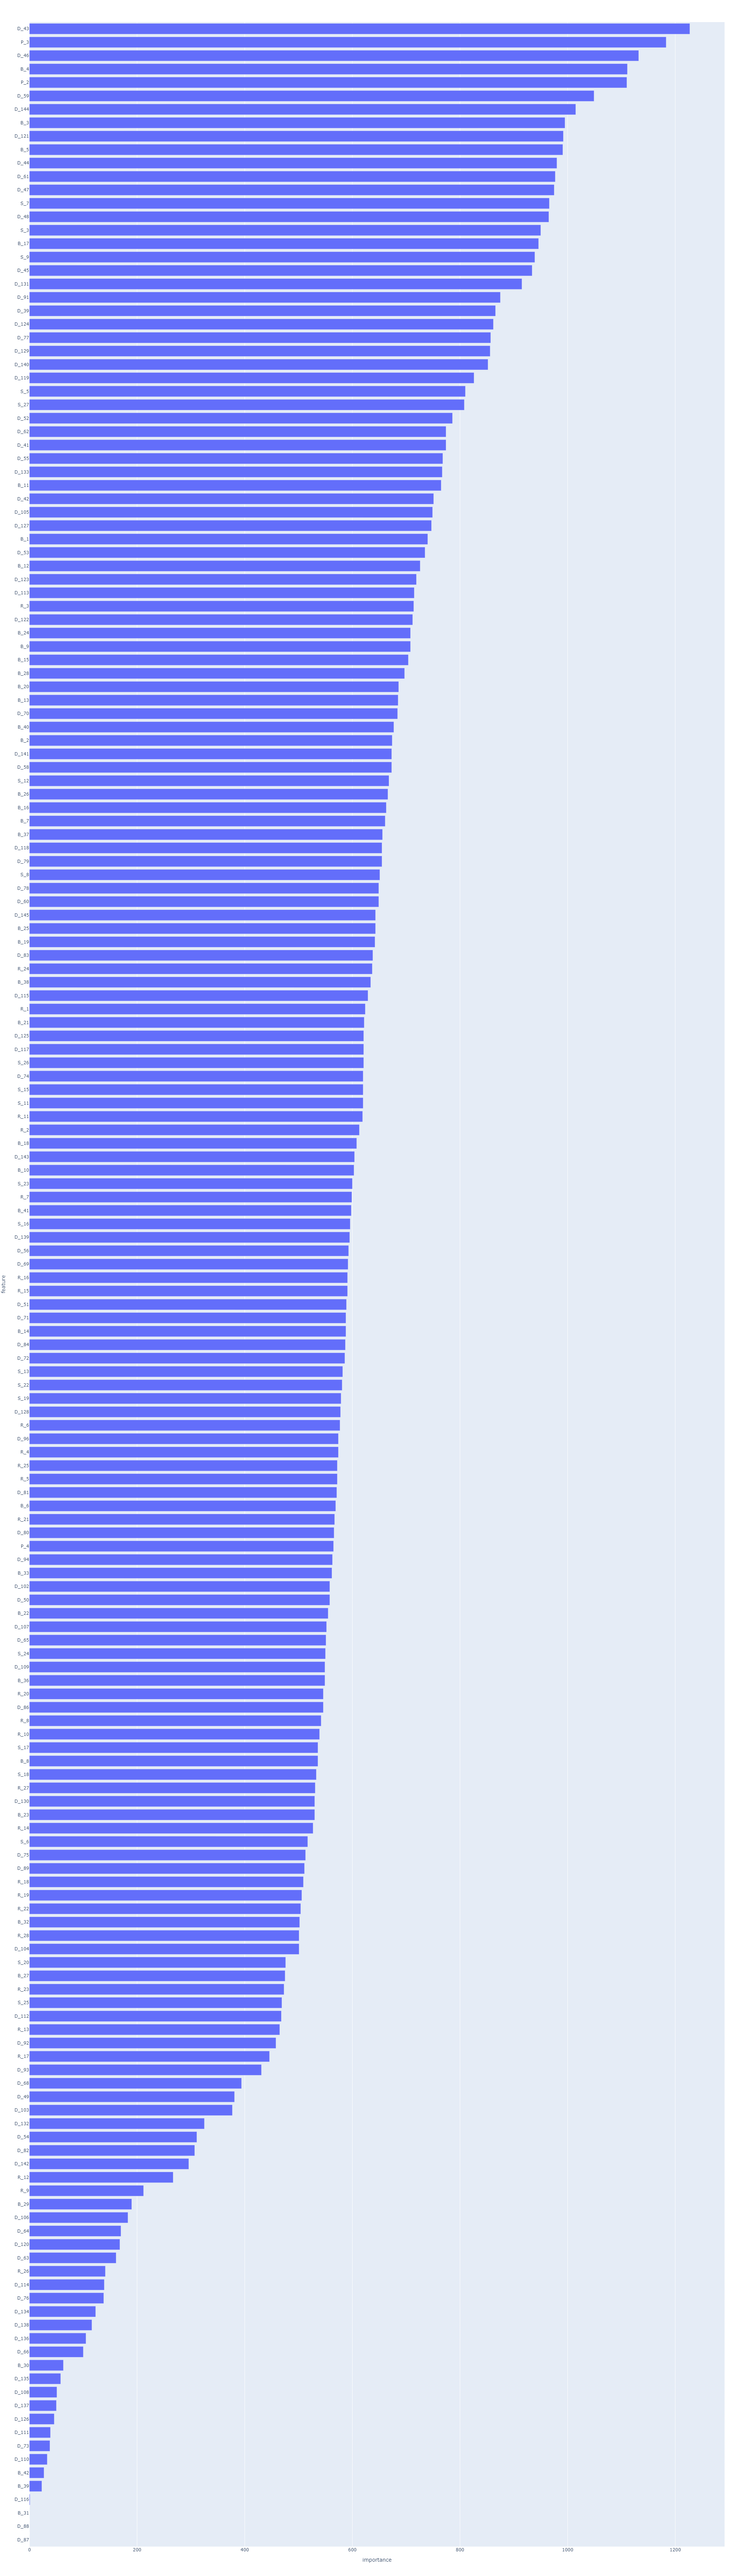

In [164]:
fig = pltex.bar(feature_imp, x='importance', y='feature', height=7000)
fig.show()

In [111]:
len(idx_train)

367131